In [1]:
#General packages
import numpy as np
import pandas as pd
from pymongo import MongoClient
from tqdm import tqdm
from scipy import stats
import statsmodels.api as sm
import json

#Figure packages
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML
import plotly.express as px
import plotly.io as pio
import matplotlib.ticker as ticker

#custom packages
import query_builder
import grocery_base

## Load Datasets

In [2]:
gdb_df=pd.read_csv('GroceryDB_foods.csv')
print(len(gdb_df))

50468


In [3]:
# Open and load the JSON file
with open('UpdatedProductIngredients_11_15.json', 'r') as file:
    ing_list=json.load(file)

In [4]:
# Function to flatten json
def flatten_ingredients(product_name,original_id,ingredients,parent_order=0,depth=1):
    rows=[]

    for ingredient in ingredients:
        # Calculate distance to first node
        distance_to_root=ingredient.get('order',0)+parent_order

        # Extract ingredient information, calculated distance, depth, and parent_order
        row = {
            'product_name': product_name,
            'original_ID': original_id,
            'ingredient_name': ingredient.get('ingredient_name'),
            'original_text': ingredient.get('original_text'),
            'general_name': ingredient.get('general_name'),
            'ingredient_type': ingredient.get('ingredient_type'),
            'order': ingredient.get('order'),
            'descriptors': ingredient.get('descriptors', []),
            'parent_order': parent_order,
            'distance_to_root': distance_to_root,
            'depth': depth
        }
        rows.append(row)

        # Rerun function for sub-ingredients
        if ingredient.get('sub_ingredients'):
            rows.extend(flatten_ingredients(product_name,original_id,
                ingredient['sub_ingredients'],parent_order=distance_to_root,depth=depth+1
            ))

    return rows

In [5]:
#Convert json into Dataframe
all_rows=[]
for product in ing_list:
    product_name=product.get('product_name')
    original_id=product.get('original_ID') 
    if product_name and product.get('ingredient_tree'):  
        all_rows.extend(flatten_ingredients(product_name,original_id,product['ingredient_tree']))

p_ingred=pd.DataFrame(all_rows)
len(p_ingred)

610766

In [6]:
#Calculate the width and depth of each product ingredient tree
p_ingred['tree_width']=None
p_ingred['sum_tree_depth']=None
p_ingred['ingred_count']=None

prods=p_ingred['original_ID'].unique()

for prod_id in tqdm(prods):
    S=p_ingred[p_ingred['original_ID']==prod_id]
    tree_width=S[S['parent_order']==0]['order'].max()
    sum_tree_depth=len(S[['parent_order','depth']].drop_duplicates())
    p_ingred.loc[S.index,'tree_width']=tree_width
    p_ingred.loc[S.index,'ingred_count']=len(S)
    p_ingred.loc[S.index,'sum_tree_depth']=sum_tree_depth
    #if len(S)<=1:
    #    p_ingred.loc[S.index,'sum_tree_depth']=0
    #else:
    #    p_ingred.loc[S.index,'sum_tree_depth']=sum_tree_depth

100%|██████████| 42540/42540 [15:27<00:00, 45.86it/s]


In [7]:
# Combine information from gdb_df into p_ingred
merged_df = p_ingred.merge(
    gdb_df[['original_ID','store','harmonized single category','f_FPro']],
    on='original_ID', how='left')
p_ingred['store'] = merged_df['store']
p_ingred['harmonized single category'] = merged_df['harmonized single category']
p_ingred['f_FPro'] = merged_df['f_FPro']

# Analyze Cereal Ingredients

In [8]:
c_ingred=p_ingred[p_ingred['harmonized single category']=='cereal'].reset_index(drop=True)

# Figure 4b

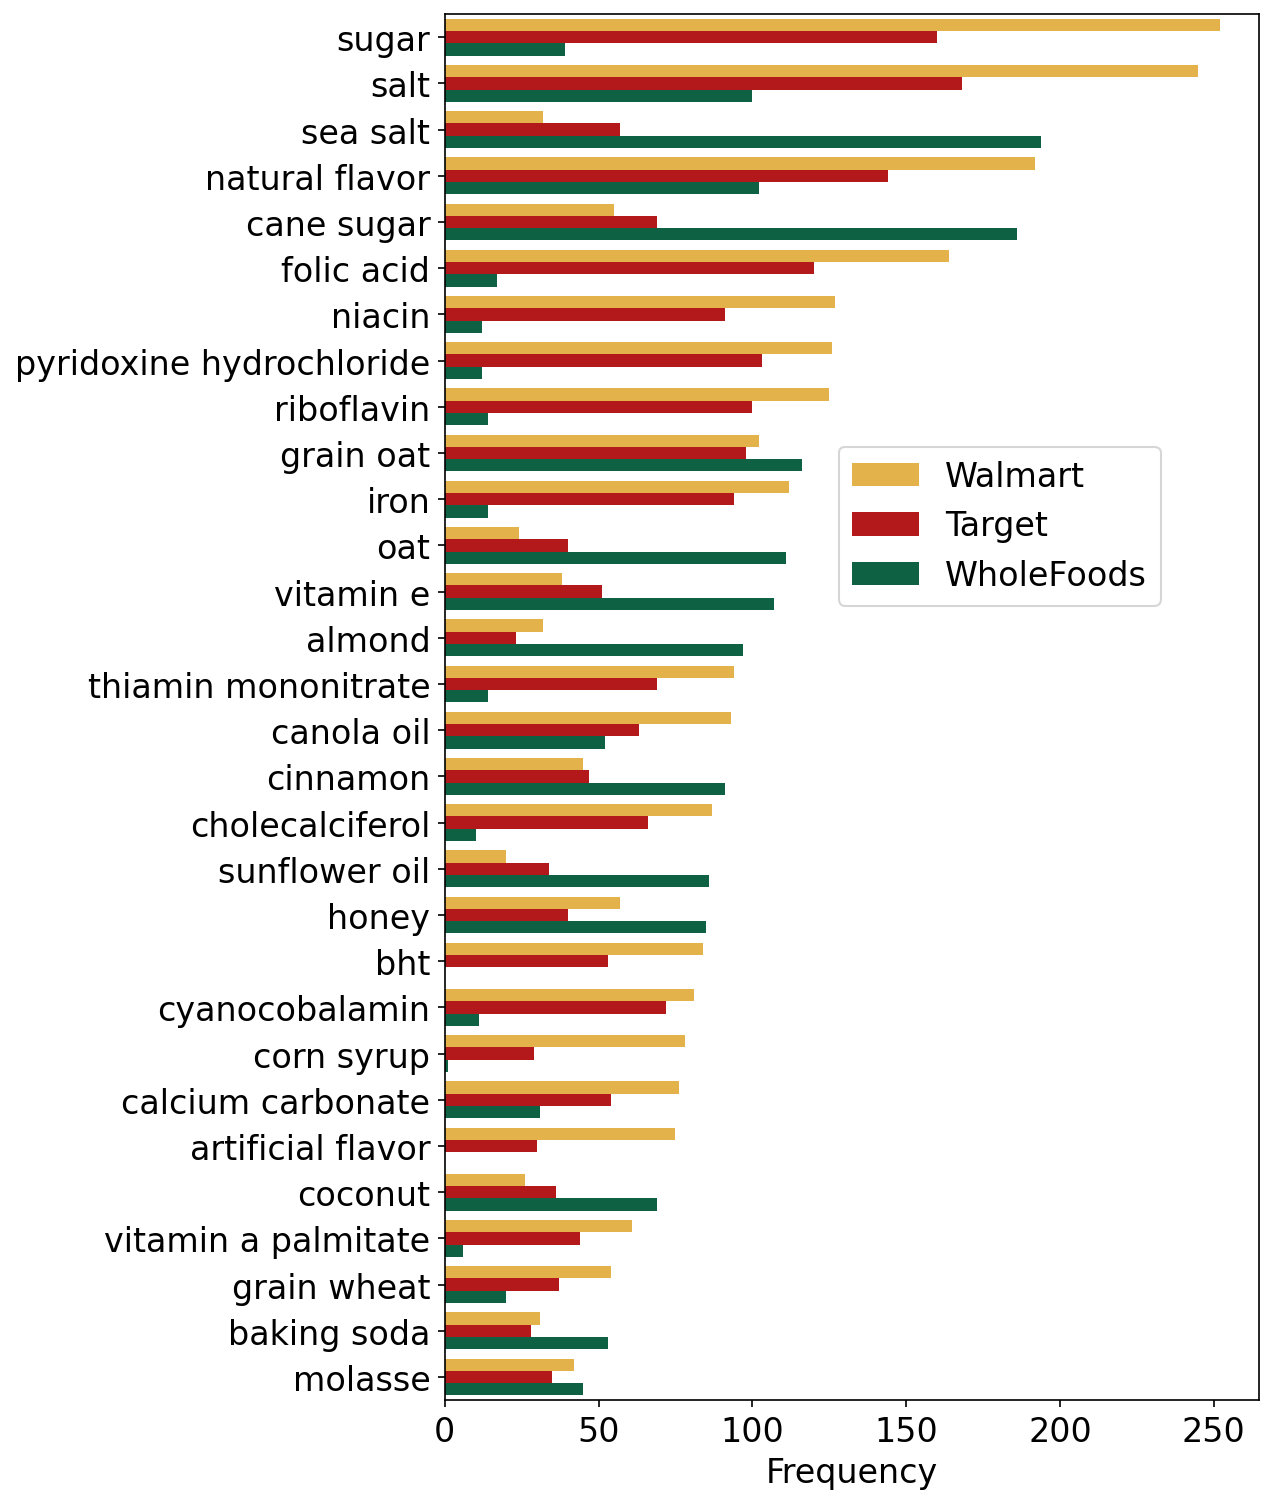

In [9]:
categorizing_strategy='store-compare-cereal'
strategy_categories = ['Walmart', 'WholeFoods', 'Target']

font_size = 16
SMALL_SIZE = font_size
MEDIUM_SIZE = font_size
BIGGER_SIZE = font_size

plt.rc('font', size=SMALL_SIZE)  # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)  # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)  # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
    
# {'additives': 'D:/SoftwareProject/GroceryDBDev/ingredient_tree/FDA_substances_added_to_food.csv'}
if True:
    col_ingred_name='general_name'
    type_ingred=['ingredient','additive']
    top_freq=[20, 30, 50][1]

    ingreds_most_imp=c_ingred[c_ingred['ingredient_type'].isin(type_ingred)]

    
    if type_ingred=='ingredient':
        ingreds_most_imp=(
            ingreds_most_imp[~ingreds_most_imp['general_name'].str.contains('sugar')]
            .reset_index(drop=True)
        )

    ingreds_most_imp=(
        ingreds_most_imp[ingreds_most_imp['ingredient_type'].isin(type_ingred)]
        .groupby(['store',col_ingred_name])
        .agg(count_ingred=('original_ID', np.size))
        .sort_values(['count_ingred'], ascending=False)
        .reset_index()
    )

    order_of_ingreds_in_plot=(
        ingreds_most_imp.groupby('general_name')
        .agg({'count_ingred': 'sum'})
        .sort_values(by='count_ingred',ascending=False)
        .reset_index()
    )

    top_ingreds=order_of_ingreds_in_plot.head(top_freq)[col_ingred_name]

''''''
# 16
# plt.figure(figsize=(9, 12), dpi=150)
plt.figure(figsize=(7, 12), dpi=150)

ingreds_most_filt_imp = ingreds_most_imp[ingreds_most_imp[col_ingred_name].isin(top_ingreds)]


ax = sns.barplot(
    y=col_ingred_name, 
    x="count_ingred",
    hue="store", 
    palette=grocery_base.colors_stores,
    hue_order = grocery_base.colors_stores.keys(),
#     col="time",
    data=ingreds_most_filt_imp
)

ax.legend(
#         fontsize=8,
        bbox_to_anchor=(0.9, 0.7)
    )

ax.set(
    xlabel='Frequency', 
    ylabel=''
)
''''''

plt.savefig('output/fig4_B.pdf', bbox_inches='tight')

if False:
    ax.set(title='Ingred-Type: {} Num-Products: {}\nType:{} | Top-ingred:{}\n'.format(
        type_ingred, len(gdb_strat_df), type_ingred, top_freq))

# Ingredient Tree Analysis

### Data for Ingredient Tree Characteristics for Products with FPro Scores

In [10]:
#filter p_ingred to necessary columns of analysis
gdb_tree_spec_FPro_df=p_ingred.drop(columns=
    ['original_text','ingredient_name','general_name','order','descriptors','parent_order','distance_to_root','depth','ingredient_type'])

In [11]:
#Remove categories with issues and entries without an FPro value
cats_ignore_analysis = {
    'coffee-beans-wf',
    'drink-juice-wf',
    'drink-water-wf',
    'eggs-wf',
    'exempt',
    'find-category',
    'maybe-bug', # includes products that stores did not provide correct nutrition facts
    'meat-poultry-wf',
    'no-category', # products that we were not able to assign to any category
    'nuts-seeds-wf',
    'produce-beans-wf',
    'rice-grains-wf',
    'seafood-wf'
}

gdb_tree_spec_FPro_df=gdb_tree_spec_FPro_df[
    ~gdb_tree_spec_FPro_df['harmonized single category']
    .isin(cats_ignore_analysis)]

gdb_tree_spec_FPro_df = gdb_tree_spec_FPro_df[
    ~gdb_tree_spec_FPro_df.isnull().any(axis=1)]

gdb_tree_spec_FPro_df=gdb_tree_spec_FPro_df.drop_duplicates().reset_index(drop=True)

print('Number of Ingredient Trees: ',len(gdb_tree_spec_FPro_df))
gdb_tree_spec_FPro_df.head()

Number of Ingredient Trees:  20489


,product_name,original_ID,tree_width,sum_tree_depth,ingred_count,store,harmonized single category,f_FPro
0,"Chocolate Raspberry Protein Bar, 1.8 oz",wf_keto-krisp-chocolate-raspberry-protein-bar-...,16,2,18,WholeFoods,snacks-bars,0.615833
1,"Seasonal Wild Blueberry Sorbet, 1 pint",wf_blue-moon-sorbet-seasonal-wild-blueberry-so...,4,1,4,WholeFoods,ice-cream-dessert,0.604246
2,Pork Sausage Links,wf_wellshire-farms-pork-sausage-links-b074vd2zhs,5,2,7,WholeFoods,sausage-bacon,0.714843
3,"Tuxedo Ice Cream Cones, 12.75 fl oz",wf_coolhaus-tuxedo-ice-cream-cones-1275-fl-oz-...,5,10,53,WholeFoods,ice-cream-dessert,0.931574
4,Butter Unsalted,wf_high-lawn-farm-butter-unsalted-2bo651jt,1,1,1,WholeFoods,culinary-ingredients,0.538449


In [12]:
cat_df = pd.merge(
    gdb_tree_spec_FPro_df.groupby('harmonized single category').agg(count_selected_category = ('original_ID', np.size)).reset_index(),
    gdb_tree_spec_FPro_df[['original_ID', 'store','harmonized single category']],
    on='harmonized single category'
)

cat_df.head()

# Add category counts to DataFrame
gdb_tree_spec_FPro_df=gdb_tree_spec_FPro_df.merge(cat_df[['original_ID','count_selected_category']],
                           on='original_ID', how='left')

### Spearman Correlation between Ingredient Tree Characteristics and Category

In [13]:
'''THIS IS ONLY FOR PRDOUCTS THAT HAVE FPro ~ 24897'''

cat_tree_spec_FPro_corr_df=[]

for cat in gdb_tree_spec_FPro_df[
        gdb_tree_spec_FPro_df['count_selected_category'] > 0 ]['harmonized single category'].unique():
    cat_df = gdb_tree_spec_FPro_df[gdb_tree_spec_FPro_df['harmonized single category'] == cat]
    
    cat_corr_dict={
        'cat': cat,
        'count items': len(cat_df)      
    }
    
    cat_tree_spec_FPro_corr_df.append(cat_corr_dict)
    
    corr, corr_pval = stats.spearmanr(cat_df['tree_width'], cat_df['sum_tree_depth'])
    cat_corr_dict['all width and depth'] = corr
    
    corr, corr_pval = stats.spearmanr(cat_df['tree_width'], cat_df['f_FPro'])
    cat_corr_dict['all width and FPro'] = corr
    
    corr, corr_pval = stats.spearmanr(cat_df['sum_tree_depth'], cat_df['f_FPro'])
    cat_corr_dict['all depth and FPro'] = corr
    
    corr, corr_pval = stats.spearmanr(cat_df['ingred_count'], cat_df['f_FPro'])
    cat_corr_dict['all ing_add and FPro'] = corr
    
    for store in grocery_base.stores:
        cat_store_df = cat_df[cat_df['store'] == store]
        cat_corr_dict[store + ' count items'] = len(cat_store_df)
        cat_corr_dict[store + ' width'] = None
        cat_corr_dict[store + ' depth'] = None
        cat_corr_dict[store + ' ing_add'] = None
        
        if len(cat_store_df) > 30:
            corr, corr_pval = stats.spearmanr(cat_store_df['tree_width'], cat_store_df['sum_tree_depth'])
            cat_corr_dict[store + ' width and depth'] = corr
            
            corr, corr_pval = stats.spearmanr(cat_store_df['tree_width'], cat_store_df['f_FPro'])
            cat_corr_dict[store + ' width and FPro'] = corr
            
            corr, corr_pval = stats.spearmanr(cat_store_df['sum_tree_depth'], cat_store_df['f_FPro'])
            cat_corr_dict[store + ' depth and FPro'] = corr
            
            corr, corr_pval = stats.spearmanr(cat_store_df['ingred_count'], cat_store_df['f_FPro'])
            cat_corr_dict[store + ' ing_add and FPro'] = corr
            pass
        pass
    pass

cat_tree_spec_FPro_corr_df = pd.DataFrame(cat_tree_spec_FPro_corr_df).sort_values(
    by=['all width and FPro'], ascending=[False]
)

if False:
    grocery_base.save_xls(
        cat_tree_spec_FPro_corr_df, 'GDB Tree Specs correlation FPro.xlsx', True, False
    )

cat_tree_spec_FPro_corr_df = (
    cat_tree_spec_FPro_corr_df[~cat_tree_spec_FPro_corr_df['cat'].isin(cats_ignore_analysis)].reset_index(drop=True)
)
    
print('Categories: ',len(cat_tree_spec_FPro_corr_df))

Categories:  44


# Figure S16

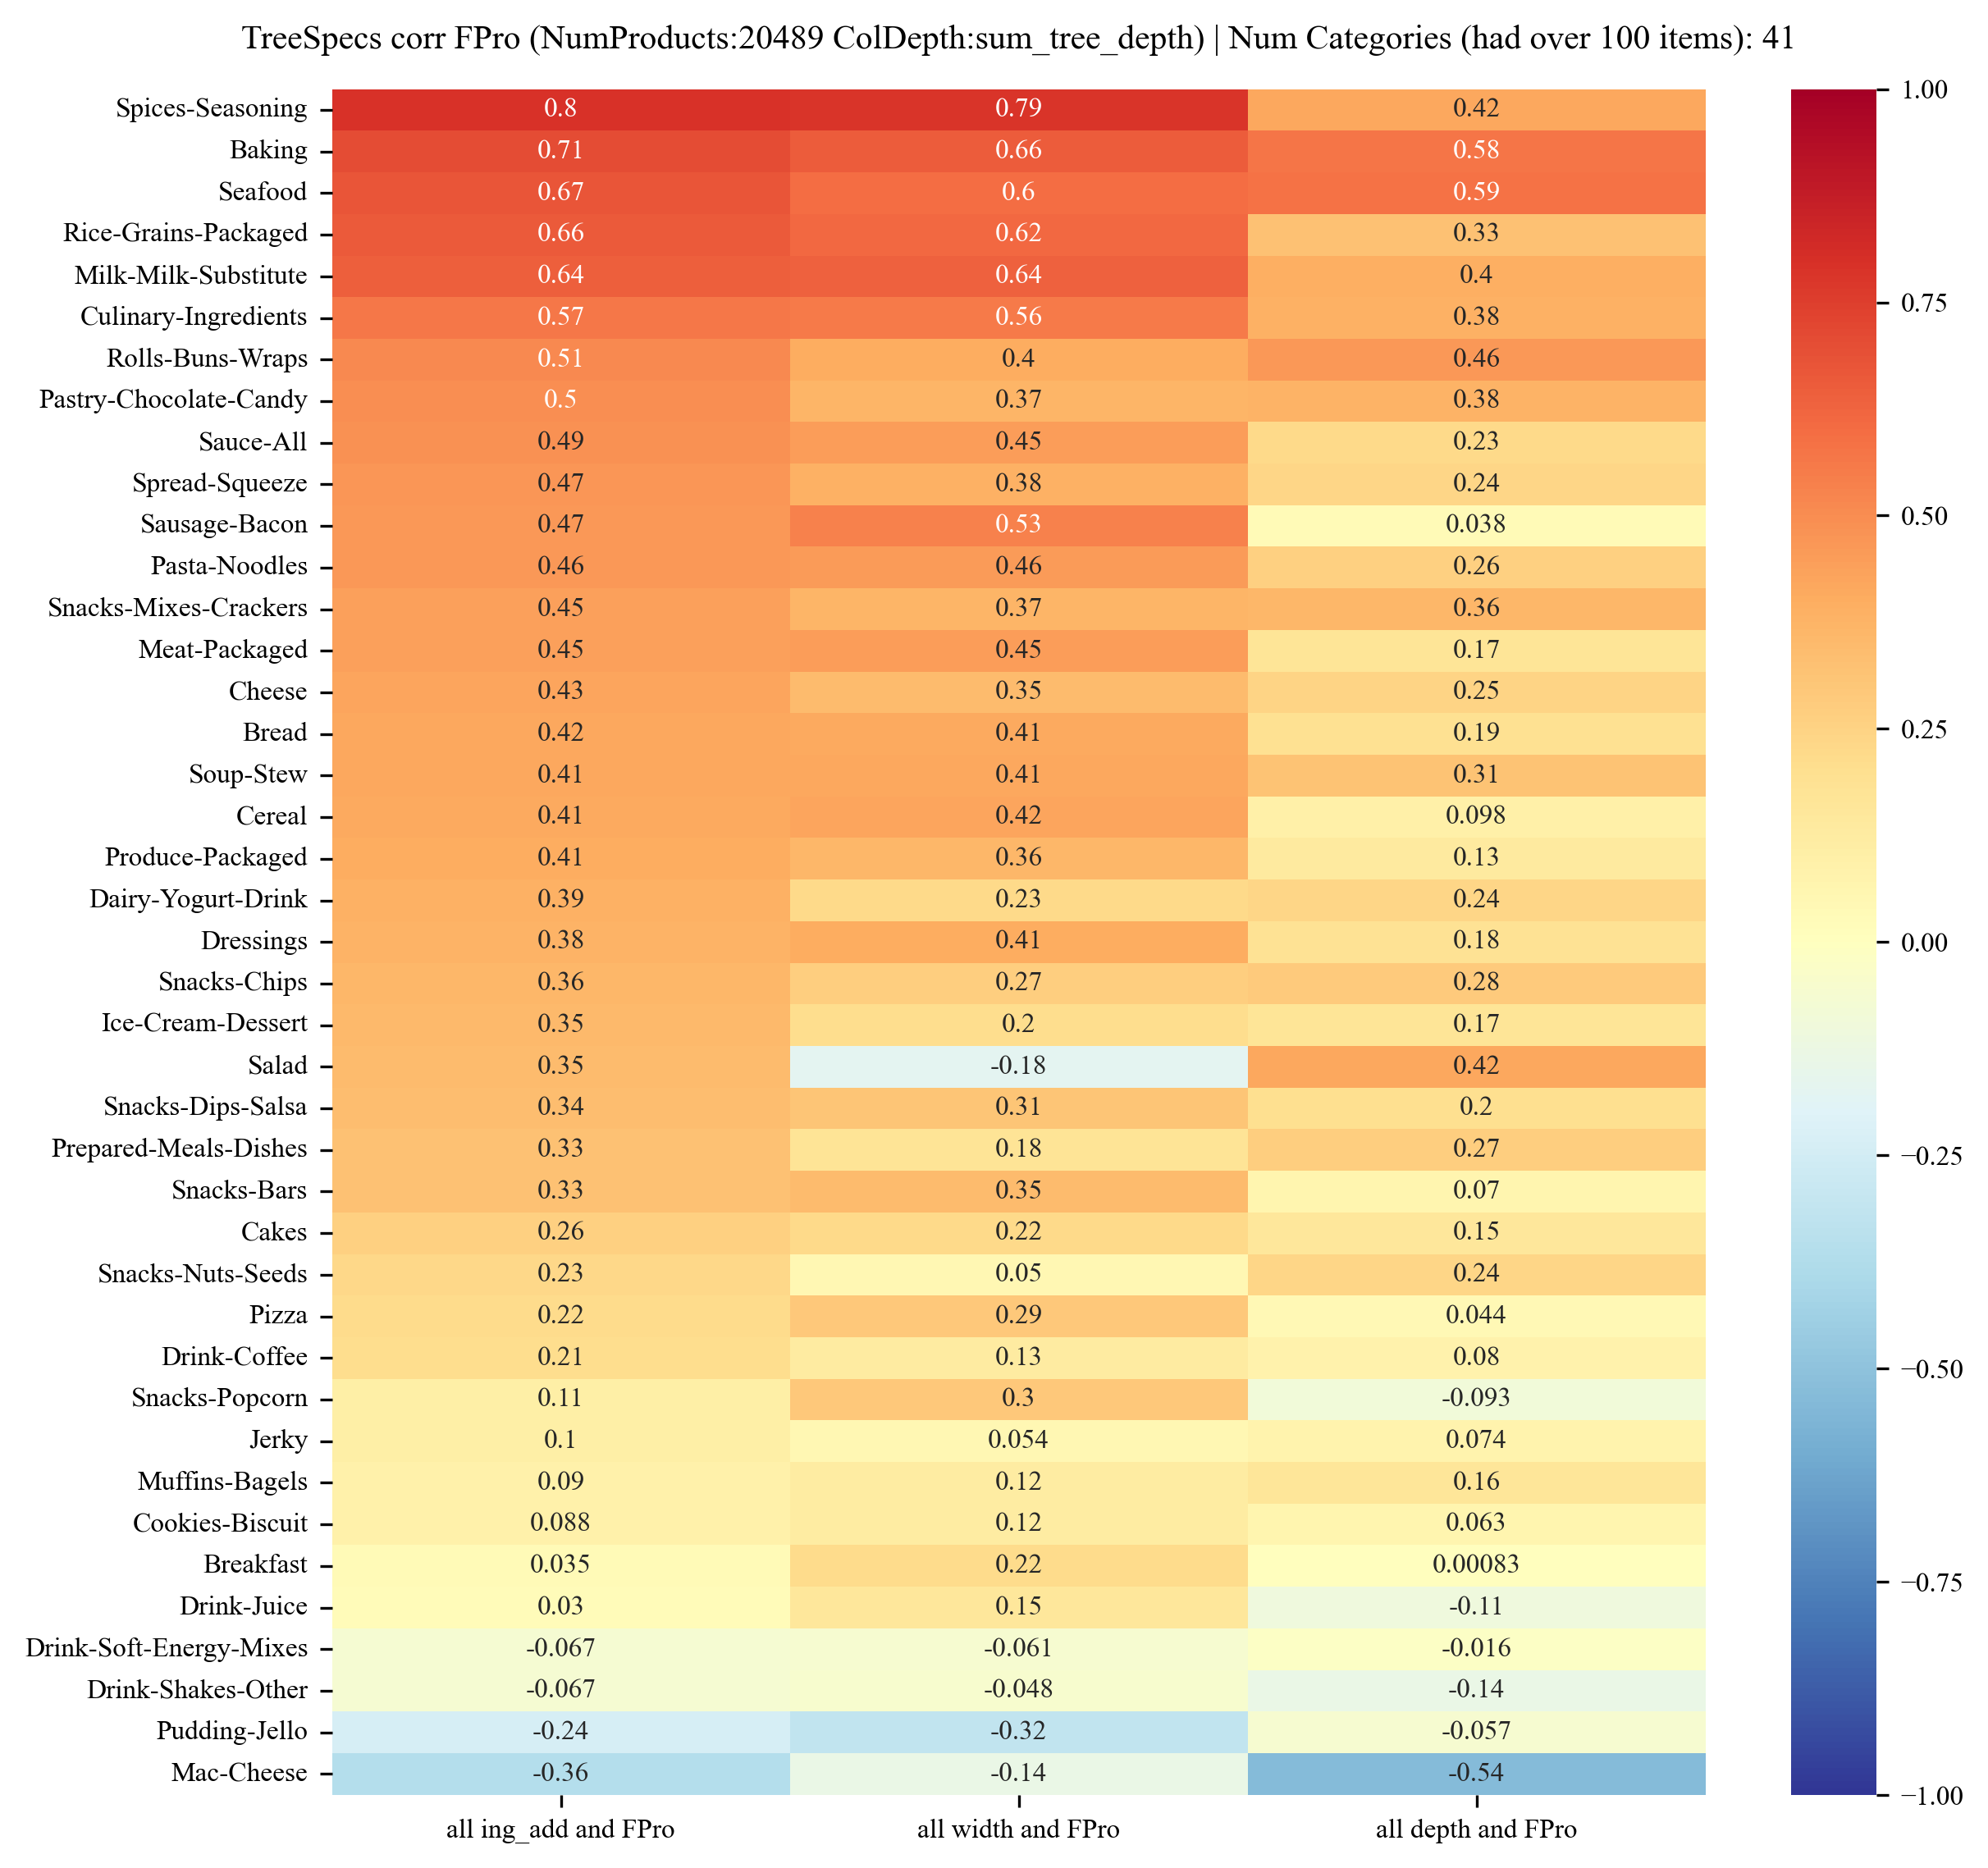

In [14]:
cols_heatmap = ['all ing_add and FPro', 'all width and FPro', 'all depth and FPro']

cat_tree_spec_FPro_corr_df = pd.DataFrame(cat_tree_spec_FPro_corr_df).sort_values(
    by=cols_heatmap[0], ascending=[False]
)

res = grocery_base.plot_correlation_matrix(
    cat_corr_df=cat_tree_spec_FPro_corr_df,
    cols_heatmap = cols_heatmap,
    filter_min_num_items_in_category=100,
    title='TreeSpecs corr FPro (NumProducts:{} ColDepth:{})'.format(len(gdb_tree_spec_FPro_df),'sum_tree_depth'), 
    vmin_vmax=(-1,1),
    figsize=(9, 9), font_size=8, add_count_items=False
)

plt.savefig('output/figS16.pdf', bbox_inches='tight')

In [15]:
gdb_tree_spec_FPro_df.describe()

,f_FPro,count_selected_category
count,20489.000000,20489.000000
mean,0.760183,734.720143
std,0.186551,389.790775
min,0.003611,1.000000
25%,0.648778,406.000000
50%,0.799069,691.000000
75%,0.911685,1005.000000
max,0.999056,1465.000000


# Figure S13a,b

['cakes', 'pizza']


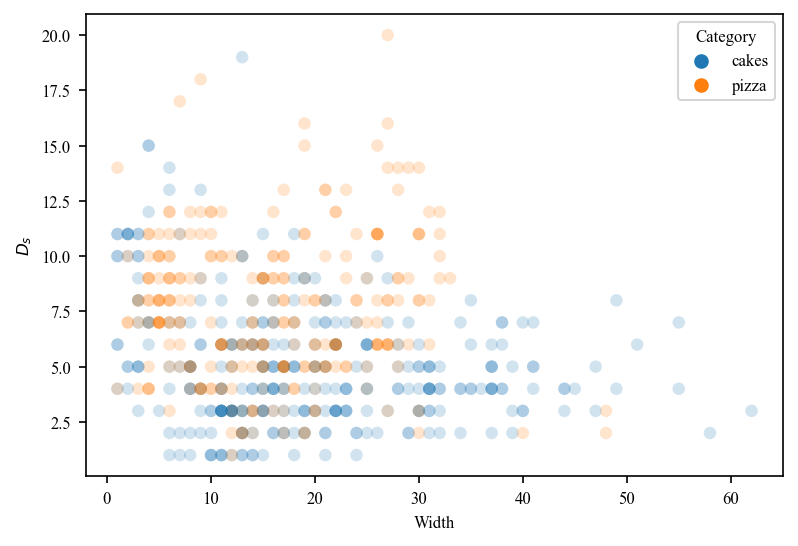

In [17]:
#categories = ['cakes', 'cheese'] #Figure S13a
categories = ['cakes', 'pizza'] #Figure S13b

print(categories)
data_df = gdb_tree_spec_FPro_df[gdb_tree_spec_FPro_df['harmonized single category'].isin(categories)]

count_products_min = 100

fig, axs = plt.subplots(1, figsize=(6, 4), dpi=150)

g = sns.scatterplot(
    data=data_df[data_df['sum_tree_depth'] < 30], 
    x="tree_width", y='sum_tree_depth',
    hue='harmonized single category', alpha=0.20, linewidth=0, 
)

plt.legend(title='Category')

g.set(xlabel='Width', ylabel='$D_s$')
# g.set(title='count_products_min: {} | col_ingred_name: {}'.format(count_products_min, col_ingred_name))

plt.savefig('output/figS13b.pdf', bbox_inches='tight')

# Figure S15a-d

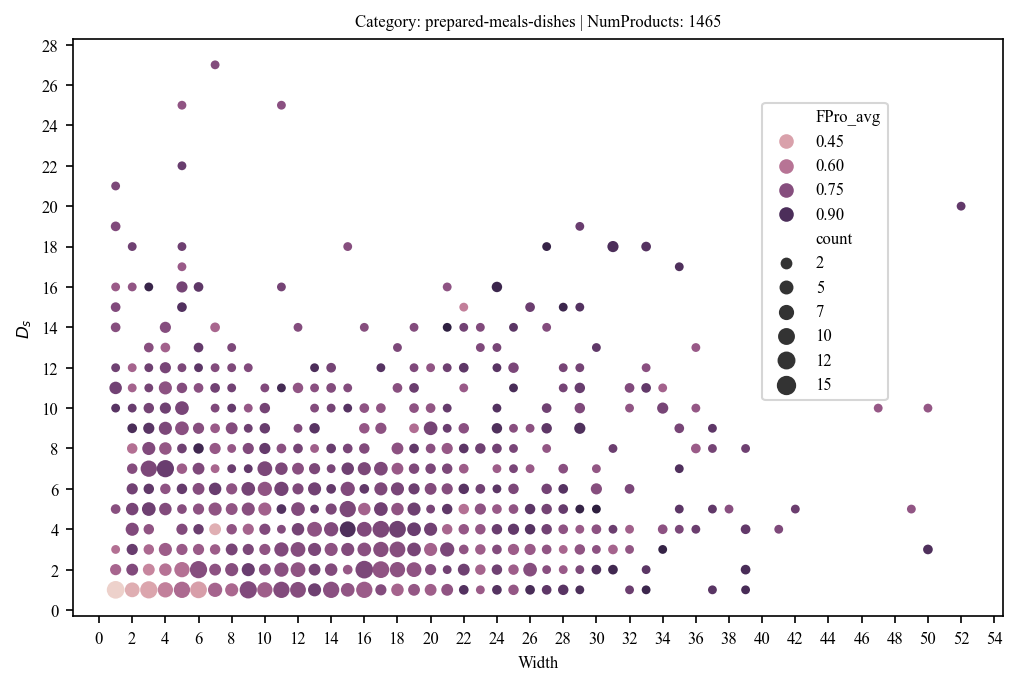

In [21]:
def plot_avg_FPro_tree_specs(category, verbose, legend_anchor):    
    data_df = gdb_tree_spec_FPro_df[gdb_tree_spec_FPro_df['harmonized single category'].isin([category])]
    data_avg_df = data_df.groupby(['tree_width','sum_tree_depth']).agg(
        FPro_avg = ('f_FPro','mean'),
        count = ('original_ID', np.size)
    ).reset_index()

    fig, axs = plt.subplots(1, figsize=(8, 5), dpi=150)

    g = sns.scatterplot(
        data=data_avg_df[data_avg_df['sum_tree_depth'] < 32], 
        x='tree_width', y='sum_tree_depth',
        hue='FPro_avg', linewidth=0, size='count'
    )

    g.xaxis.set_major_locator(ticker.MultipleLocator(2))
    g.yaxis.set_major_locator(ticker.MultipleLocator(2))
    g.legend( bbox_to_anchor=legend_anchor)

    g.set(xlabel='Width', ylabel='$D_s$')
    
    title = 'Category: {} | NumProducts: {}'.format(category, len(data_df))
    
    if verbose:
        g.set(title=title)
    else:
        print(title)
    pass

#category = 'cereal' #Figure S15a
#category = 'pasta-noodles' #Figure S15b
#category = 'baking' #Figure S15c
category = 'prepared-meals-dishes' #Figure S15d

legend_anchor_dict = {'cereal': (0.72, 0.38), 'pasta-noodles': (0.79, 0.32), 'baking': (0.79, 0.41),'prepared-meals-dishes': (0.732, 0.36)}
legend_anchor_val = (1.00, 1.01)

if category in legend_anchor_dict:
    legend_anchor_val = legend_anchor_dict[category]
plot_avg_FPro_tree_specs(category, verbose=True, legend_anchor=legend_anchor_val)

plt.savefig('output/figS15d.pdf', bbox_inches='tight')

# Figure S14a

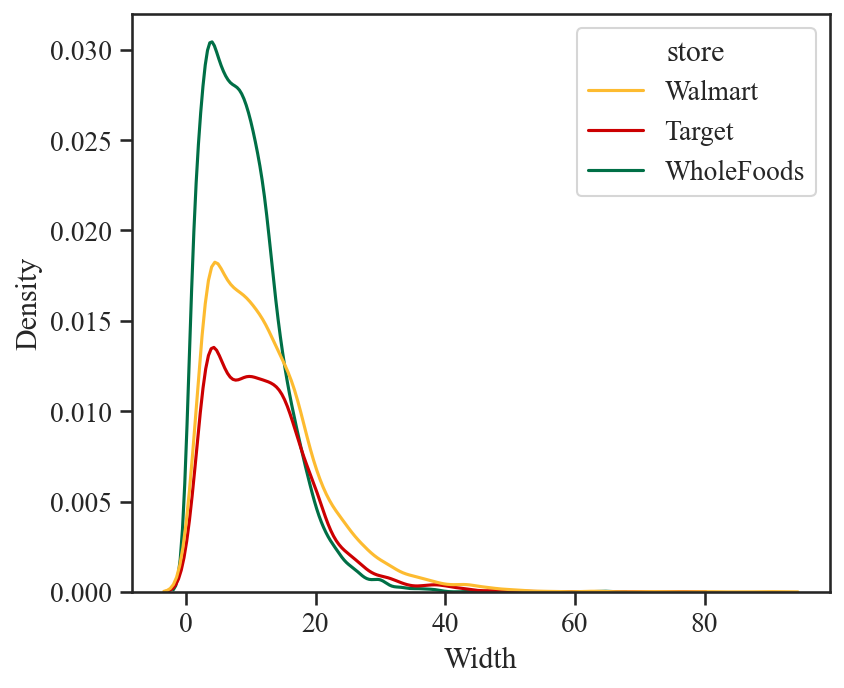

In [25]:
fig, axs = plt.subplots(1, figsize=(6,5), dpi=150)

sns.set(style="ticks", font="Times New Roman", font_scale=1.2)
sns.set_style({'font.family': 'serif', 'font.serif': 'Times New Roman'})

ax = sns.kdeplot(data=gdb_tree_spec_FPro_df, x='tree_width', hue='store', ax=axs,
                 palette=grocery_base.colors_stores, hue_order=grocery_base.colors_stores.keys())
ax.set(xlabel='Width', ylabel='Density')

if False:
    plt.title(
        'Distribution of Tree Width | Num Data: {}'.format(
            len(gdb_tree_spec_FPro_df)))
    pass

plt.savefig('output/figS14a.pdf', bbox_inches='tight')

# Figure S14b

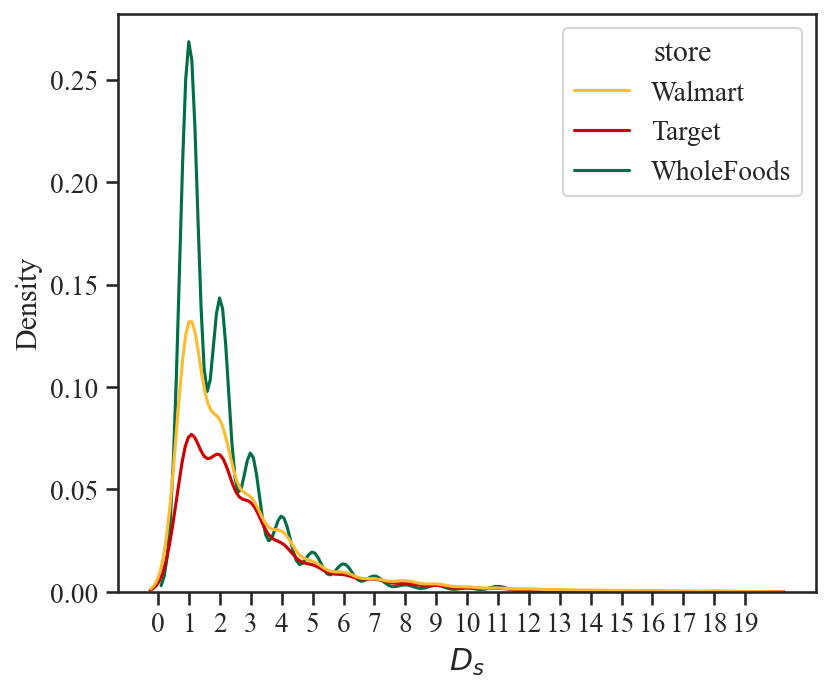

In [26]:
fig, axs = plt.subplots(1, figsize=(6,5), dpi=150)

sns.set(style="ticks", font="Times New Roman", font_scale=1.2)
sns.set_style({'font.family': 'serif', 'font.serif': 'Times New Roman'})

data_df = gdb_tree_spec_FPro_df[gdb_tree_spec_FPro_df['sum_tree_depth'] < 20]

ax = sns.kdeplot(data=data_df, x='sum_tree_depth', hue='store', ax=axs,
                palette=grocery_base.colors_stores, hue_order=grocery_base.colors_stores.keys())
ax.set(xlabel='$D_s$', ylabel='Density')

plt.xticks(range(0, int(data_df['sum_tree_depth'].max()) + 1, 1))

if False:
    plt.title(
        'Distribution of Tree depth | Num Data: {}'.format(
            len(gdb_tree_spec_FPro_df)))
    
plt.savefig('output/figS14b.pdf', bbox_inches='tight')

### Calculate Correlation between Tree Characteristics for each Category

In [28]:
cat_tree_spects_corr_df = []

for cat in gdb_tree_spec_FPro_df[
        gdb_tree_spec_FPro_df['count_selected_category'] > 0
    ]['harmonized single category'].unique():
#     print(cat)
    cat_df = gdb_tree_spec_FPro_df[gdb_tree_spec_FPro_df['harmonized single category'] == cat]
    
    cat_corr_dict = {
        'cat': cat,
        'count items': len(cat_df)
        
    }
    cat_tree_spects_corr_df.append(cat_corr_dict)
    
    corr, corr_pval = stats.spearmanr(cat_df['tree_width'], cat_df['sum_tree_depth'])
    cat_corr_dict['All Stores'] = corr
    
    cat_corr_dict['all ' + 'tree_width' + ' mean'] = cat_df['tree_width'].mean()
    cat_corr_dict['all ' + 'tree_width' + ' std'] = cat_df['tree_width'].std()

    cat_corr_dict['all ' + 'sum_tree_depth' + ' mean'] = cat_df['sum_tree_depth'].mean()
    cat_corr_dict['all ' + 'sum_tree_depth' + ' std'] = cat_df['sum_tree_depth'].std()
    
    for store in grocery_base.stores:
        cat_store_df = cat_df[cat_df['store'] == store]
        cat_corr_dict[store] = None
        cat_corr_dict[store + ' count items'] = len(cat_store_df)
        
        cat_corr_dict[store + ' ' + 'tree_width' + ' mean'] = cat_store_df['tree_width'].mean()
        cat_corr_dict[store + ' ' + 'tree_width' + ' std'] = cat_store_df['tree_width'].std()
        
        cat_corr_dict[store + ' ' + 'sum_tree_depth' + ' mean'] = cat_store_df['sum_tree_depth'].mean()
        cat_corr_dict[store + ' ' + 'sum_tree_depth' + ' std'] = cat_store_df['sum_tree_depth'].std()
        
        if len(cat_store_df) > 10:
            corr, corr_pval = stats.spearmanr(cat_store_df['tree_width'], cat_store_df['sum_tree_depth'])
            cat_corr_dict[store] = corr
            pass
        pass
    pass

cat_tree_spects_corr_df = pd.DataFrame(cat_tree_spects_corr_df).sort_values(by='All Stores', ascending=False)

if False:
    grocery_base.save_xls(
        cat_tree_spects_corr_df, 'GDB Tree Specs correlation.xlsx', True, False
    )

cat_tree_spects_corr_df.head()

,cat,count items,All Stores,all tree_width mean,all tree_width std,all sum_tree_depth mean,all sum_tree_depth std,Walmart,Walmart count items,Walmart tree_width mean,...,Target tree_width mean,Target tree_width std,Target sum_tree_depth mean,Target sum_tree_depth std,WholeFoods,WholeFoods count items,WholeFoods tree_width mean,WholeFoods tree_width std,WholeFoods sum_tree_depth mean,WholeFoods sum_tree_depth std
3,culinary-ingredients,177,0.560365,5.672316,5.490174,1.333333,0.704423,0.422040,71,8.436620,...,2.500000,1.732051,1.000000,0.000000,0.659916,102,3.872549,4.055730,1.274510,0.599618
17,milk-milk-substitute,412,0.558071,6.233010,4.418395,1.359223,0.551121,0.480387,75,6.666667,...,8.179487,4.494861,1.641026,0.777553,0.587882,298,5.869128,3.959346,1.365772,0.529058
31,baking,353,0.543056,6.660057,5.414419,1.742210,1.172048,0.530043,146,8.424658,...,8.473684,5.396379,2.184211,1.608344,0.416953,169,4.727811,3.691592,1.313609,0.637978
29,seafood,346,0.535595,7.127168,6.494235,1.647399,1.465529,0.457828,125,7.648000,...,8.313559,7.701370,1.805085,1.531763,0.551758,103,5.135922,4.359008,1.203883,0.530616
14,spices-seasoning,229,0.457689,6.065502,5.997813,1.310044,0.769446,0.236630,47,11.170213,...,10.285714,5.154748,2.000000,0.816497,0.415983,175,4.525714,4.775196,1.160000,0.451816


# Figure S14c

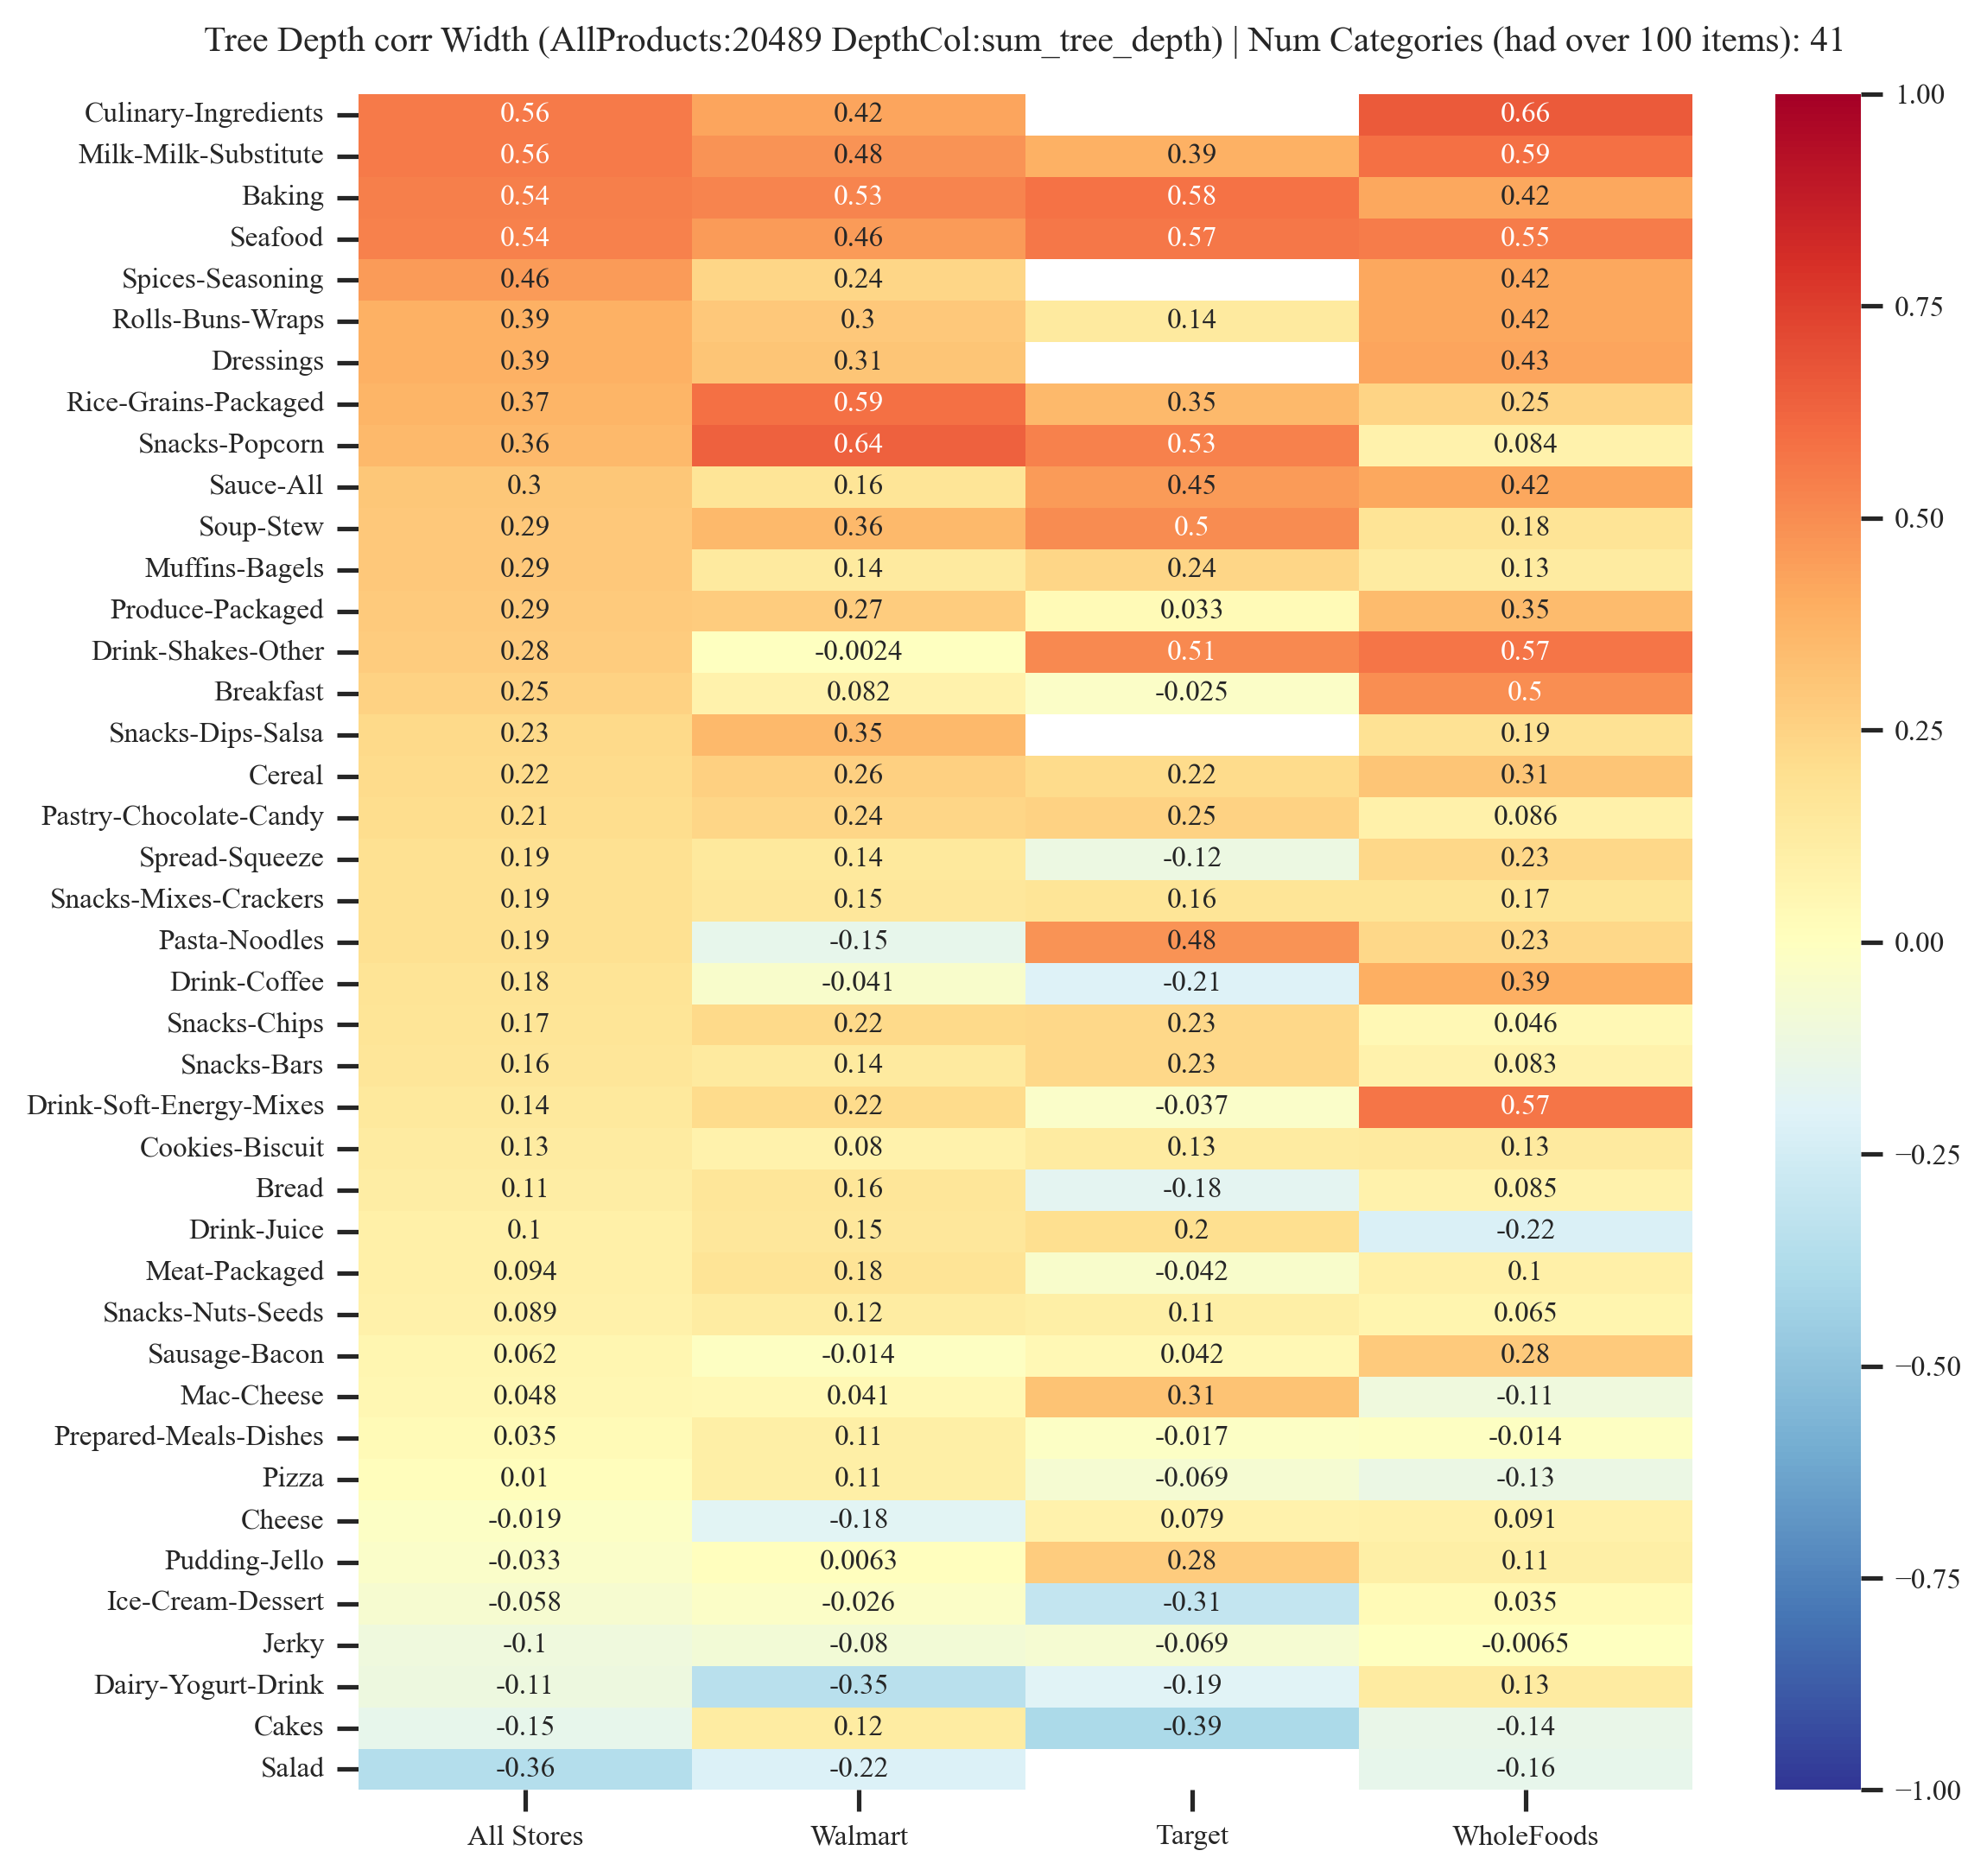

In [29]:
res = grocery_base.plot_correlation_matrix(
    cat_corr_df=cat_tree_spects_corr_df, 
    filter_min_num_items_in_category=100,
    cols_heatmap = ['All Stores'] + grocery_base.stores,
    title='Tree Depth corr Width (AllProducts:{} DepthCol:{})'.format(len(gdb_tree_spec_FPro_df), 'sum_tree_depth'),
    figsize=(8.3, 8.5),font_size=8, add_count_items=False, vmin_vmax=(-1,1)
)

plt.savefig('output/figS14c.pdf', bbox_inches='tight')